# Lab. TRIL - Carbon Capture and Storage

Engenharia Computacional para a Emissão Zero no Setor de Óleo e Gás

## Introdução 

Esse é um programa que realiza um processo de leitura, processamento e análise de um conjunto de dados de um reservatório, para encontrar classes de injetividade apresentadas com análise de gráfico.

Esse projeto é desenvolvido por:<br>
* Yhasmim de Souza Tigre - Aluna de Iniciação Científica - UFPB
* Prof. Dr. Gustavo C. Oliveira - Professor Orientador - UFPB


### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle
from numba import jit 
#%matplotlib inline 
#from matplotlib.pyplot import plotpip 

In [2]:
import warnings

#Serve para ignorar os 'red warnings' que algumas bibliotecas apontam porque tem novas versoes de implementacao
warnings.filterwarnings('ignore') 

## 1 - Preparação de Files 

Essas funções devem receber arquivos csv (em uma formatação pré-estabelecida) que serem lidos, checados e iniciados.<br>
Os arquivos precisam:
* ter colunas nomeadas (de preferência em ordem alfabética)
* não ter valores NAN

In [3]:
'''função de leitura do arquivo csv para df'''

def read_df(df):

    df = pd.read_csv(df)
    if any(df.isna()):
        print("df com valores NAN")
        
        df = df.fillna(0)
        print("df corrigido, não mais possui valores NAN")
    
    return df

In [56]:
'''função de checagem de keys em dataframe '''

def checking(df):
    
    df = read_df(df)

    lista_primarias = ['RQI','pressao','pressao_inversa','distancia','permeabilidade','porosidade']
    lista_Js = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8']  
    
    #encontrando keys estrangeiras no df
    for i in df.keys():         
        if lista_primarias.count(i) == 0: 
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')                 
        if lista_Js.count(i) == 0:
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis secundarias Js. \n')

    #encontrando keys faltantes no df
    for i in lista_primarias:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel primaria "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')
    for i in lista_Js:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel secundária "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis secundária Js. \n')
        
    return df

## 2 - Calculo dos J's

In [59]:
'''função de normalização dos dados'''

def normalization(df, J, norm=False):

    df = read_df(df)
    # df = checking(df)
    
    #atribuição        
    for j in J: 
              
        if j == 'J1':
            J1 = df['RQI']
            df['J1'] = J1
            normalize_(df, j, norm)            
                    
        if j == 'J2':
            J2 = df['RQI']*df['pressao']
            df['J2'] = J2
            normalize_(df, j, norm)

        if j == 'J3':
            J3 = df['RQI']*df['pressao_inversa']
            df['J3'] = J3
            normalize_(df, j, norm)                                                                                         
                            
        if j == 'J4':
            #para evitar resultados infinitos
            aux = np.log(df['distancia']) #calc do log(0 ind, 1 inf)
            #mascara
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J4 = df['RQI'] * df['pressao'] * aux      
            df['J4'] = J4
            normalize_(df, j, norm) 

        if j == 'J5':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J5 = df['RQI'] * df['pressao_inversa'] * aux
            df['J5'] = J5
            normalize_(df, j, norm)
        
        if j == 'J6':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J6 = df['permeabilidade'] * df['porosidade'] * aux
            df['J6'] = J6
            normalize_(df, j, norm)  

    return df

def normalize_(df, col, norm):
    if norm == True:   
        df[f'{col}_normalizado'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

## 3- Processamento Binning <br> (Bayesian Blocks ou KDE)
<br/>
A classe binning é responsável por processar os dados em KDE ou Bayesian Blocks

In [63]:
#@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
class binning():

        #método construtor
        def __init__(self) -> None:
            pass        
        
        #@jit(nopython=True)
        def proc_binning(df, J, binning): 

            if binning == 'kde':
                
                '''Bibliotecas'''
                import numpy as np
                from numpy import array, linspace
                from sklearn.neighbors import KernelDensity
                from scipy.misc import electrocardiogram
                from scipy.signal import argrelmin, find_peaks
                from sklearn.model_selection import GridSearchCV, LeaveOneOut
                import scipy.integrate as integrate                        
    
                '''Recebendo df'''
                #para testes com valores simplificados
                df = read_df(df)

                #para valores ja normalizados
                #df = checking(df)

                #para valores que passaram por normalização
                #J = ['J1']
                #df = normalization (df, J, norm=True)

                #pegando um valor menor para rodar o codigo
                df = df.sample(1500)

                '''Método de bandwith para kde'''
                #BANDWIDTH ORIGINAL: 0.01
                ideal_band = 0
                for coluna in J:                   
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)
                
                    band = np.linspace(0.01, 0.05)
                    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut())
                    grid.fit(X[:,None].reshape(-1, 1)) 
                    ideal_band = grid.best_params_
                    #print(ideal_band)                
                   
                '''Calculo kde'''
                resultados_kde = {}

                for coluna in J:
                    
                    min_i = 0
                    max_i = df[f'{coluna}'].shape[0]#pega a dimensao da coluna 
                    aux = max_i - min_i
                    #print("aux", aux)

                    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)
                    #print("x", X)

                    # calculo da densidade de probabilidade
                    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)
                    #print("kde", kde)
                    
                    #retorna os pontos em uma distancia equidistante / os dados precisam está em 2D
                    dist = np.linspace([0], [1.0], aux)
                    #print("dist", dist)

                    #calcula a probabilidade logarítmica de cada amostra sob o modelo                     
                    #for i in range(len(dist)):
                    log = kde.score_samples(dist.reshape(-1,1))
                    #faz uma multiplicação entre os valores de dist e log resolvendo o problema de dimensões diferentes
                    #dist.dot(log)
                    #print("log", log)                   
                    
                    # usamos exponencial para deixar log positivo
                    #essa integral retorna o valor True ou False (estava retornando valor antes das modificações em dist e log)
                    # [:, None] é usado para realizar o broadcast dos dados (operação entre arrays de dimensões diferentes))
                    integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())
                    #print(integral)
                    
                    #if 0.99 <= integral <= 1.01:
                    if integral <= 1.01 and integral >= 0.99:
                        print(f'A integral : {integral} é adequeada.')
                    else:
                        print(f'A integral não está no intervalo correto: {integral}')
                        raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')
                                                           
                    '''Calculo das Particoes'''
                    # calcula os picos
                    peaks = find_peaks(log, height=min(log)) 
                    #Calcula a minima relativa dos dados
                    valleys = argrelmin(log)[0] 
                    
                    #Retorna os indices que classificam o array em ordem crescente
                    ord = np.argsort(np.abs(np.diff(log[valleys])))
                    #inverte a ordem do array 
                    ordValleys_J = np.flip(ord)+1 


                    #Contrução dos intervalos de classe 
                    #utiliza o intervalo de 0 a 1 para encontrar os pontos de partição usando a minima relativa
                    ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))
                    classes = {}
                    for i in range(1, len(ov)):
                        classes[i] = (ov[i-1], ov[i])                    
                                      
                    #retorno de funcão KDE com dicionario

                    resultados_kde[coluna] = {}
                    
                    resultados_kde[coluna]['dist'] = dist
                    resultados_kde[coluna]['log'] = log
                    resultados_kde[coluna]['peaks'] = peaks
                    resultados_kde[coluna]['valleys'] = valleys
                    resultados_kde[coluna]['ordValleys_J'] = ordValleys_J
                    resultados_kde[coluna]['classes'] = classes

                return resultados_kde   
                
            
            '''Calculo Bayesian Blocks'''

            if binning == 'bb':
                from astropy.stats import bayesian_blocks

                
                resultados_bb = {}

                for coluna in df.columns:
                    if coluna in df.columns[12::]:
                        serie = df.query(f"{coluna} > 0")[coluna]
                        resultados_bb[coluna] = [serie, bayesian_blocks(serie)]

            return resultados_bb
            

In [66]:
'''Adição do padding '''

def padding(df, J):

    df = binning.proc_binning(proc, J, binning='kde')

    padDF = np.pad(df, (0.01, 0.01)) #para a melhor localização de pontos divisores de classe
    return padDF    

## 4 - Pickle

In [41]:
def pickle (df, fileout):
    import pickle as pkl 

## 5 - Análise dos Gráficos

### Graficos dos Binnings

In [68]:
class graficos:

    #método construtor
    def __init__(self) -> None:

        plt.style.use(".dados/plot/ccs.mplstyle")
    
    def grafico_kde(proc, J, pad = False):        

        import matplotlib.pyplot as plt

        #df deve ser aquele resultante do processamento
        df = binning.proc_binning(proc, J, binning='kde')

        if padding == True:
            df = padding(df)

        for coluna in df:                        
            plt.plot(df[coluna]['dist'], df[coluna]['log'])

        """for i in J:           
            
            plt.title(f'Vales dos Kernels | {i} normalizado')
            plt.ylabel("Densidade")
            plt.xlabel(f'Posição assumida por {i} norm')                      
            
            plt.plot(df[coluna]['valleys'], df[coluna]['log'][df[coluna]['valleys']], 'o')
            plt.plot(df[coluna]['valleys'][df[coluna]['ordValleys_J'][0:4]], df[coluna]['log'][df[coluna]['valleys'][df[coluna]['ordValleys_J'][0:4]]], '*', c='red')
            
            for j in coluna:
                plt.plot(int(coluna['classes'][j]))
            plt.show()

            for j in df[i]['valleys']:
                print(df[i]['valleys'][j])"""
                

    def grafico_bb(df, bins_bb, J):

        df = binning.proc_binning(df, J, binning='bb')

        """
        Essa funcao tem como objetivo criar uma representação gráfica
        de uma determinada 'coluna' de um determinado DataFrame (df)
        dado o calculo de seus bins/classes baseados no Bayesian Blocks.
        Pode-se obter os Bayesian Blocks de uma determinada variável
        usando a funcao 'bayesian_blocks' do módulo astropy.stats
        """
                
        
        labels = {
            "J1_normalizado" : "RQI",
            "J2_normalizado" : "RQI * Pressao",
            "J3_normalizado" : "RQI * Pressao Inversa",
            "J4_normalizado" : "RQI * Pressao * ln(distancia)",
            "J5_normalizado" : "RQI * Pressao Inversa * ln(distancia)", 
            "J6_normalizado" : "Permeabilidade * Porosidade * ln(distancia)",
            "J7_normalizado" : "ln(Permeabilidade) * ln(Porosidade) * ln(distancia)"
        }
        
        ax = plt.figure(figsize=(20, 12))
        #modificar labels para for
        ax = plt.title(f"Histograma '{J} = {labels[J]}' utilizando blocos bayesianos", fontsize = 24)
        ax = plt.xlabel("X", fontsize = 18)
        ax = plt.ylabel("Y", fontsize = 18)
        ax = plt.hist(df, bins = bins_bb, color='g')
        ax = plt.grid(True)
        plt.savefig(f'./dados/Analise de Js/bb/{J}.jpeg', format='jpeg')
        plt.show(ax)
        

## 6 - Main 

Aqui vamos chamar o pipeline e apresentar opções ao usuário chamando as funções

In [34]:
#chamando arquivo csv
arq = pd.read_csv("./dados/Simplificados/J1_reduzido.csv")
# "./dados/variaveis2.csv"

In [45]:
#chamando a funções de preparação
arq = read_df("./dados/Simplificados/J1_reduzido.csv") 
#arq = read_df("./dados/variaveis2.csv")
#arq = checking(arq)

df com valores NAN
df corrigido, não mais possui valores NAN


In [64]:
J = ['J1']
#J = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6']

proc = binning.proc_binning("./dados/Simplificados/J1_reduzido.csv", J, binning='kde')
#proc = binning.proc_binning(arq, J, binning='bb')

df com valores NAN
df corrigido, não mais possui valores NAN
A integral : 1.0 é adequeada.


In [ ]:
pad = 

df com valores NAN
df corrigido, não mais possui valores NAN
A integral : 1.0 é adequeada.


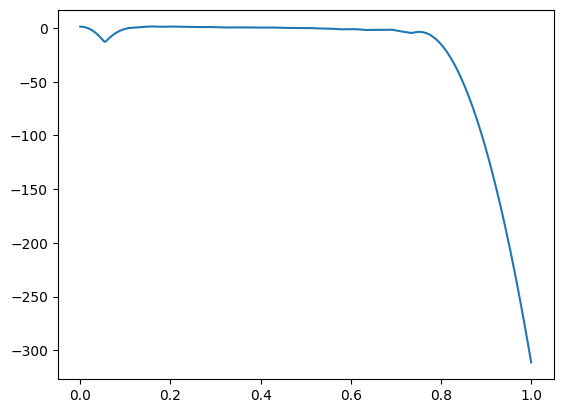

In [69]:
J = ['J1']
pl = graficos.grafico_kde("./dados/Simplificados/J1_reduzido.csv", J, pad = True) #debug

# Testes


In [ ]:
'''cont = 0
for coluna in variaveis_df.columns[12:]:
    for valor in variaveis_df[coluna]:
        if valor <= 0:
            print(coluna, valor)
        else:
            cont += 1
            
#verificando se há algum valor nulo ou menor que nulo. Não temos!
#verifica se o total é igual ao n de linhas * n de colunas dos J's normalizados
cont == variaveis_df.shape[0] * len(variaveis_df.columns[12:])'''

In [ ]:
'''#gerando gráficos bb
resultados = {}

for coluna in variaveis_df.columns:
    if coluna in variaveis_df.columns[12::]:
        serie = variaveis_df.query(f"{coluna} > 0")[coluna]
        resultados[coluna] = [serie, bayesian_blocks(serie)]
        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)'''